# Real-time monitoring tool

Here only the functions of the back-end will be developed. Later-on, these functions will be passed into an interactive dashboard

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from osgeo import gdal
import geopandas as gpd
from itertools import repeat
import folium
import rasterio
import rioxarray as rxr
import xarray as xr

## 1. Building the fundamentals

### 1.1 Importing the database and selecting the dates

In [8]:
os.chdir('D:/Repos/PirnaCaseStudy/Data/Databases')
os.listdir()

['DiverID.csv', 'GWL.csv', 'WellID_edited.csv']

In [22]:
gwl_fn , wells_fn = 'GWL.csv', 'WellID_edited.csv'
gwl_df , wells_df  = pd.read_csv(gwl_fn) , pd.read_csv(wells_fn)
gwl_df['Date'] = pd.to_datetime (gwl_df['Date']).dt.date

In [17]:
wells_df.head()

,WellID,CaseHeight,Type,Diameter,Depth,FilterTop,FilterBase,E,N
0,G01,119.49,Well,1.0,14.0,1.0,13.0,13.922657,50.965827
1,G02,118.83,Drilling,1.0,14.0,NaN,NaN,13.922918,50.965820
2,G03,118.73,Drilling,1.0,14.0,NaN,NaN,13.923160,50.965840
3,G04,119.19,Well,1.0,14.0,1.0,13.0,13.923426,50.965848
4,G04neu,120.09,Well,1.0,14.0,6.0,13.0,13.923416,50.965847


Indexing below. 
In the future, when we build the databases, we will need to create a database for variables and IDs.

**Ideas for database**

1. WellID = already existent. Gives an ID (integer) to each well. Contains every information about the well.
    * Add river point
2. DiverID = Non-existent. Gives an ID to each diver.
    * It should contain:
        * Company's name
            * That will be a proxy to activate the formula to convert readings into heads
3. WellDiver = Connects Divers to Wells 
    * Important for filling the database
    * Every diver present here is activated
    * It should contain:
        * The diver depth
        * Manual or non-manual reading    
4. GWL = Already existent. Register readings. Need to replace WellID for ID from WellID table.
    * Add river point

**Find an user-friendly solution for INOWAS to edit the database**

**Indexing**: 

Below we define the objects to select the date. The user will be able to select it from the dashboard

In [105]:
#user input
Date = '04/02/2021'
Hour = 1
Variable = 0

In [106]:
Date = pd.to_datetime('01/17/2022').date()

dates_df = gwl_df.loc[(gwl_df.Date == Date)
                      & (gwl_df.Hour == Hour)
                      & (gwl_df.Variable == Variable)
                     ].dropna().reset_index()
#merging coordinates to dataset

dates_df = pd.merge(dates_df, wells_df[['WellID', 'E', 'N']],
              on = 'WellID'
             ).drop(columns=['Variable','Hour','Date', 'index'])
dates_df

,WellID,Head,E,N
0,G01,9.259000,13.922657,50.965827
1,G10,9.038000,13.923311,50.966071
2,G11,6.711000,13.923868,50.965732
3,G12,6.339000,13.923290,50.965675
4,G13,6.760000,13.922816,50.965641
5,G17,5.501000,13.923634,50.965507
6,G19,5.331000,13.923159,50.965430
7,G23,8.827000,13.922428,50.966182
8,GWM2,110.300003,13.923774,50.965905
9,GWM3,110.199997,13.923764,50.965858


### 1.2 Building the interpolation tool

Store one value of river reading and build a function here to create several points along the river

In [107]:
points = np.array(dates_df[['E','N']])
values = np.array(dates_df.Head)

minx, maxx = dates_df.E.min(), dates_df.E.max()
miny, maxy =  dates_df.N.min(), dates_df.N.max()

grid_x, grid_y = np.mgrid[minx:maxx:50j, miny:maxy:50j]

In [108]:
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

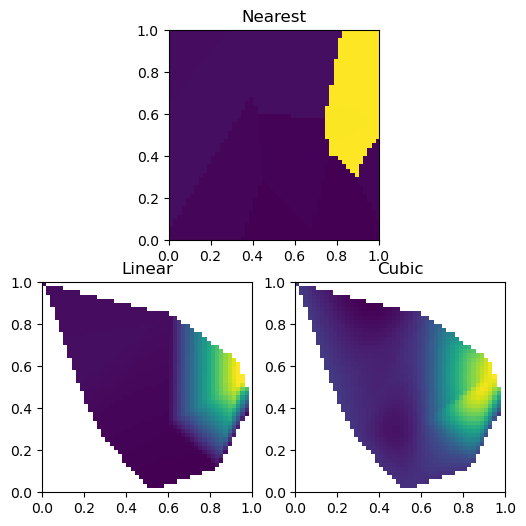

In [109]:
plt.subplot(211)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

**Here Zhao recommended to do use linear interpolation**

## 2. Update the database

Here we need to check the API file and send request data river and groundwater data from the cloud to fill the database with the missing dates. When setting-up the dashboard, this will be a separate function.